# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

# added to verify GPU is being utilized instead of CPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

F:\Anaconda3\envs\RoboND\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11127782216272278756
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 6789848269
locality {
  bus_id: 1
}
incarnation: 14866791929422851403
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0"
]


## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsample_sil = bilinear_upsample(small_ip_layer)

    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output = layers.concatenate([upsample_sil, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [62]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    x_encoded1 = encoder_block(inputs, 64, 2)
    x_encoded2 = encoder_block(x_encoded1, 128, 2)    
    x_encoded3 = encoder_block(x_encoded2, 256, 2)        

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    x_conv = conv2d_batchnorm(x_encoded3, 512)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x3 = decoder_block(x_conv, x_encoded2, 256)    
    x2 = decoder_block(x3, x_encoded1, 128)    
    x = decoder_block(x2, inputs, 64)    
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [63]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [64]:
learning_rate = 0.01
batch_size = 32
num_epochs = 100
steps_per_epoch = 128
validation_steps = 37
workers = 5

Epoch 1/100
127/128 [============================>.] - ETA: 0s - loss: 0.1522

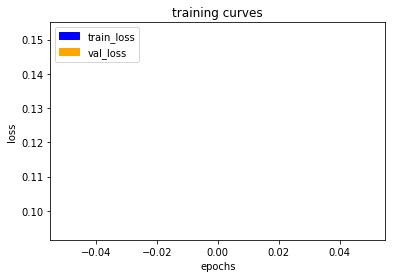

128/128 [==============================] - 79s - loss: 0.1514 - val_loss: 0.0944
Epoch 2/100
127/128 [============================>.] - ETA: 0s - loss: 0.0457

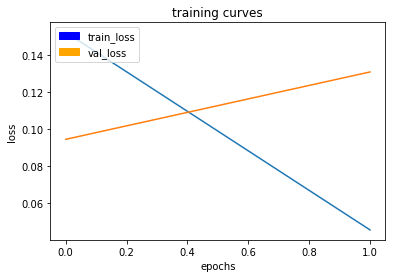

128/128 [==============================] - 78s - loss: 0.0456 - val_loss: 0.1307
Epoch 3/100
127/128 [============================>.] - ETA: 0s - loss: 0.0401

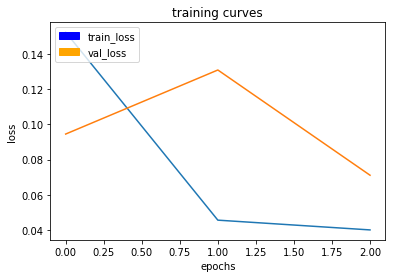

128/128 [==============================] - 77s - loss: 0.0400 - val_loss: 0.0711
Epoch 4/100
127/128 [============================>.] - ETA: 0s - loss: 0.0361

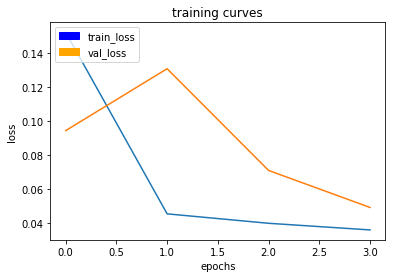

128/128 [==============================] - 78s - loss: 0.0361 - val_loss: 0.0494
Epoch 5/100
127/128 [============================>.] - ETA: 0s - loss: 0.0337

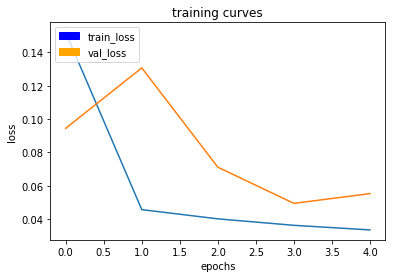

128/128 [==============================] - 77s - loss: 0.0337 - val_loss: 0.0553
Epoch 6/100
127/128 [============================>.] - ETA: 0s - loss: 0.0339

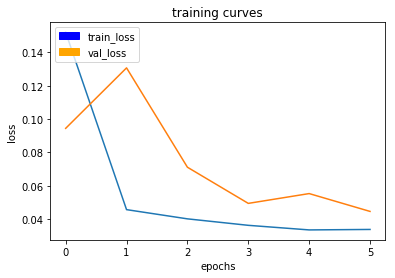

128/128 [==============================] - 77s - loss: 0.0338 - val_loss: 0.0446
Epoch 7/100
127/128 [============================>.] - ETA: 0s - loss: 0.0301

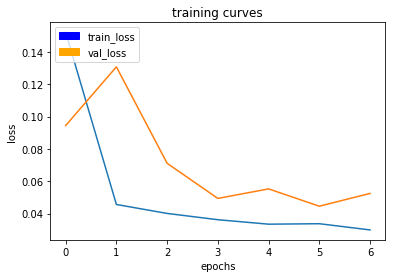

128/128 [==============================] - 78s - loss: 0.0302 - val_loss: 0.0525
Epoch 8/100
127/128 [============================>.] - ETA: 0s - loss: 0.0306

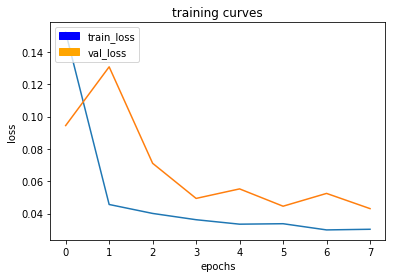

128/128 [==============================] - 78s - loss: 0.0306 - val_loss: 0.0431
Epoch 9/100
127/128 [============================>.] - ETA: 0s - loss: 0.0285

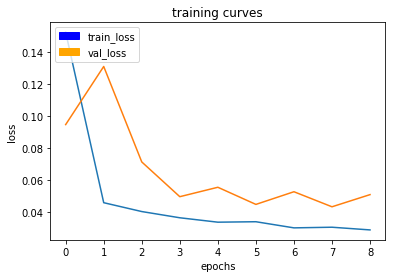

128/128 [==============================] - 78s - loss: 0.0285 - val_loss: 0.0507
Epoch 10/100
127/128 [============================>.] - ETA: 0s - loss: 0.0266

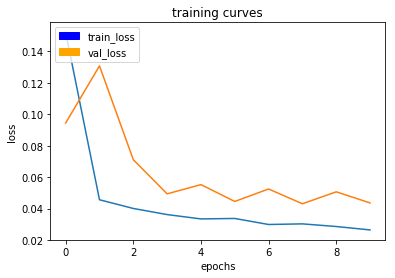

128/128 [==============================] - 78s - loss: 0.0266 - val_loss: 0.0436
Epoch 11/100
127/128 [============================>.] - ETA: 0s - loss: 0.0249

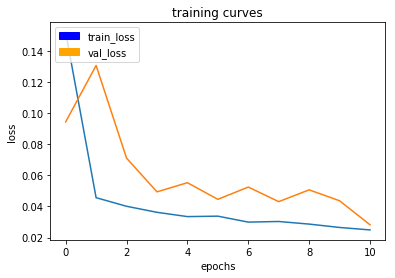

128/128 [==============================] - 78s - loss: 0.0249 - val_loss: 0.0282
Epoch 12/100
127/128 [============================>.] - ETA: 0s - loss: 0.0226

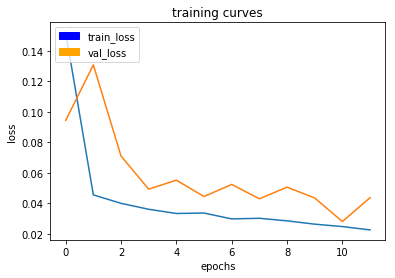

128/128 [==============================] - 77s - loss: 0.0227 - val_loss: 0.0438
Epoch 13/100
127/128 [============================>.] - ETA: 0s - loss: 0.0228

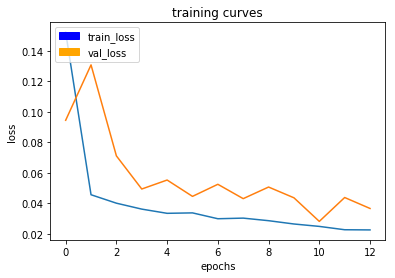

128/128 [==============================] - 78s - loss: 0.0227 - val_loss: 0.0366
Epoch 14/100
127/128 [============================>.] - ETA: 0s - loss: 0.0223

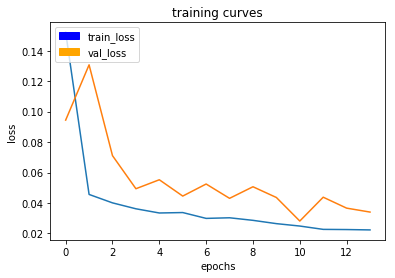

128/128 [==============================] - 78s - loss: 0.0223 - val_loss: 0.0341
Epoch 15/100
127/128 [============================>.] - ETA: 0s - loss: 0.0211

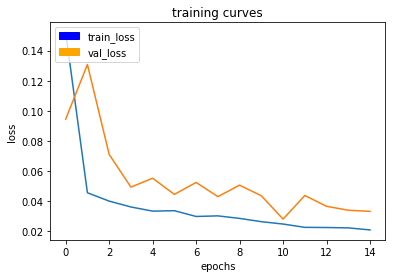

128/128 [==============================] - 78s - loss: 0.0211 - val_loss: 0.0333
Epoch 16/100
127/128 [============================>.] - ETA: 0s - loss: 0.0208

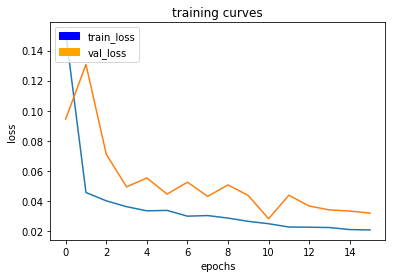

128/128 [==============================] - 78s - loss: 0.0208 - val_loss: 0.0319
Epoch 17/100
127/128 [============================>.] - ETA: 0s - loss: 0.0186

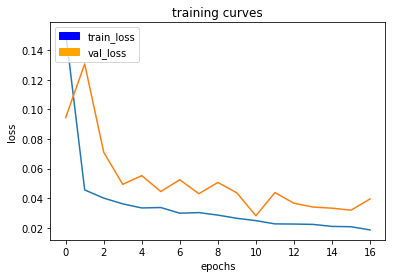

128/128 [==============================] - 78s - loss: 0.0186 - val_loss: 0.0395
Epoch 18/100
127/128 [============================>.] - ETA: 0s - loss: 0.0188

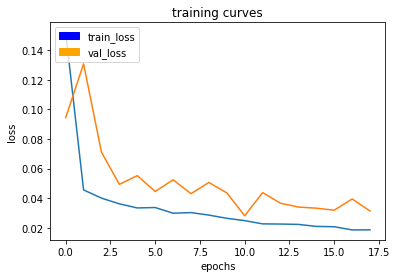

128/128 [==============================] - 78s - loss: 0.0188 - val_loss: 0.0314
Epoch 19/100
127/128 [============================>.] - ETA: 0s - loss: 0.0189

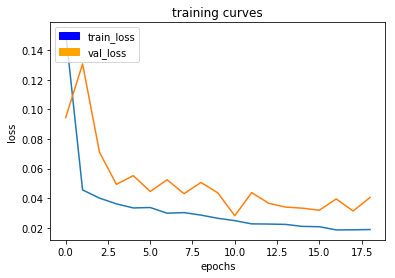

128/128 [==============================] - 77s - loss: 0.0189 - val_loss: 0.0405
Epoch 20/100
127/128 [============================>.] - ETA: 0s - loss: 0.0186

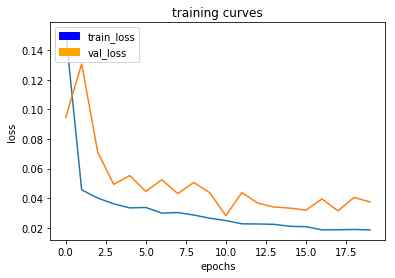

128/128 [==============================] - 77s - loss: 0.0186 - val_loss: 0.0374
Epoch 21/100
127/128 [============================>.] - ETA: 0s - loss: 0.0177

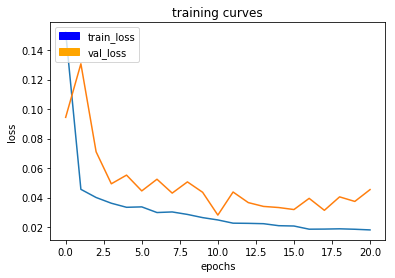

128/128 [==============================] - 77s - loss: 0.0182 - val_loss: 0.0455
Epoch 22/100
127/128 [============================>.] - ETA: 0s - loss: 0.0190

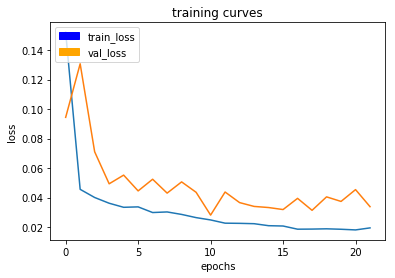

128/128 [==============================] - 78s - loss: 0.0194 - val_loss: 0.0339
Epoch 23/100
127/128 [============================>.] - ETA: 0s - loss: 0.0168

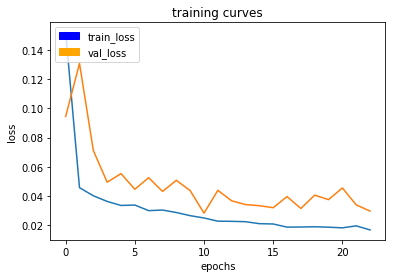

128/128 [==============================] - 77s - loss: 0.0168 - val_loss: 0.0296
Epoch 24/100
127/128 [============================>.] - ETA: 0s - loss: 0.0147

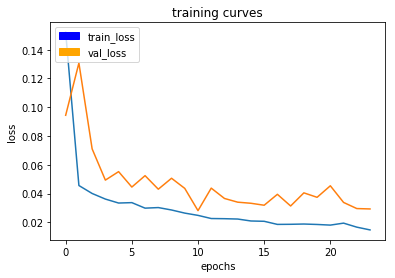

128/128 [==============================] - 78s - loss: 0.0147 - val_loss: 0.0294
Epoch 25/100
127/128 [============================>.] - ETA: 0s - loss: 0.0134

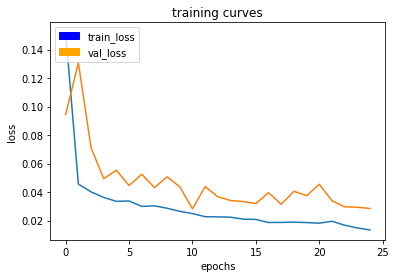

128/128 [==============================] - 78s - loss: 0.0134 - val_loss: 0.0284
Epoch 26/100
127/128 [============================>.] - ETA: 0s - loss: 0.0178

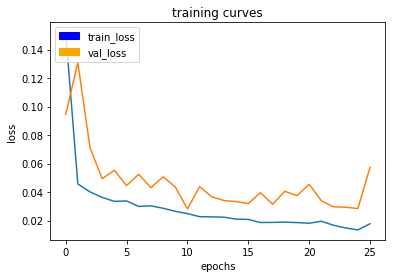

128/128 [==============================] - 78s - loss: 0.0178 - val_loss: 0.0574
Epoch 27/100
127/128 [============================>.] - ETA: 0s - loss: 0.0167

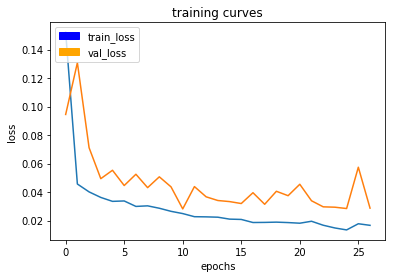

128/128 [==============================] - 77s - loss: 0.0167 - val_loss: 0.0287
Epoch 28/100
127/128 [============================>.] - ETA: 0s - loss: 0.0148

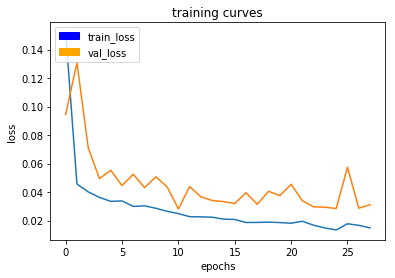

128/128 [==============================] - 78s - loss: 0.0148 - val_loss: 0.0311
Epoch 29/100
127/128 [============================>.] - ETA: 0s - loss: 0.0135

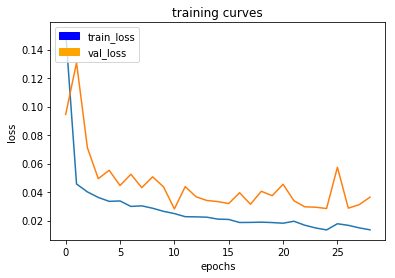

128/128 [==============================] - 77s - loss: 0.0135 - val_loss: 0.0364
Epoch 30/100
127/128 [============================>.] - ETA: 0s - loss: 0.0142

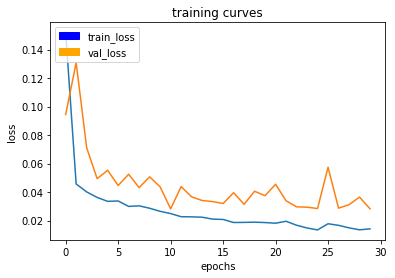

128/128 [==============================] - 78s - loss: 0.0142 - val_loss: 0.0282
Epoch 31/100
127/128 [============================>.] - ETA: 0s - loss: 0.0141

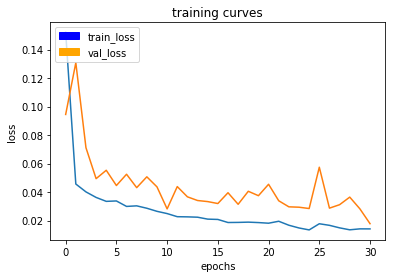

128/128 [==============================] - 78s - loss: 0.0141 - val_loss: 0.0178
Epoch 32/100
127/128 [============================>.] - ETA: 0s - loss: 0.0125

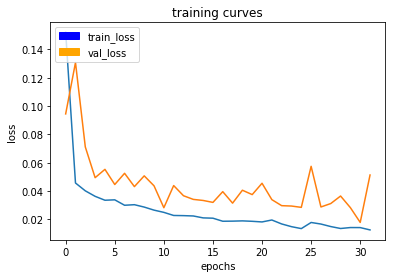

128/128 [==============================] - 78s - loss: 0.0125 - val_loss: 0.0513
Epoch 33/100
127/128 [============================>.] - ETA: 0s - loss: 0.0140

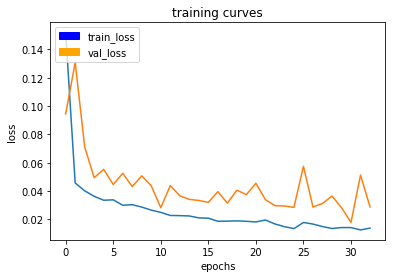

128/128 [==============================] - 77s - loss: 0.0140 - val_loss: 0.0287
Epoch 34/100
127/128 [============================>.] - ETA: 0s - loss: 0.0139

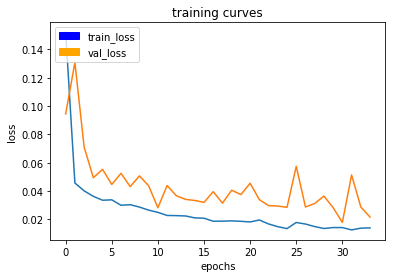

128/128 [==============================] - 78s - loss: 0.0139 - val_loss: 0.0216
Epoch 35/100
127/128 [============================>.] - ETA: 0s - loss: 0.0133

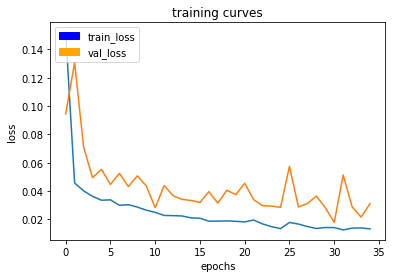

128/128 [==============================] - 78s - loss: 0.0133 - val_loss: 0.0311
Epoch 36/100
127/128 [============================>.] - ETA: 0s - loss: 0.0136

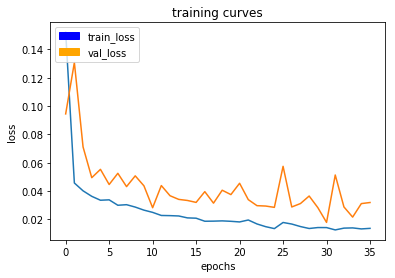

128/128 [==============================] - 78s - loss: 0.0136 - val_loss: 0.0319
Epoch 37/100
127/128 [============================>.] - ETA: 0s - loss: 0.0126

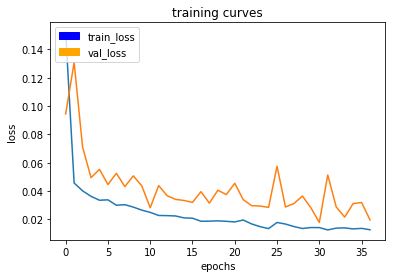

128/128 [==============================] - 77s - loss: 0.0126 - val_loss: 0.0196
Epoch 38/100
127/128 [============================>.] - ETA: 0s - loss: 0.0109

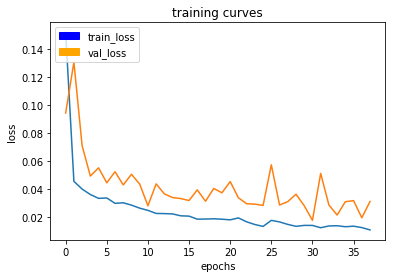

128/128 [==============================] - 77s - loss: 0.0109 - val_loss: 0.0312
Epoch 39/100
127/128 [============================>.] - ETA: 0s - loss: 0.0139

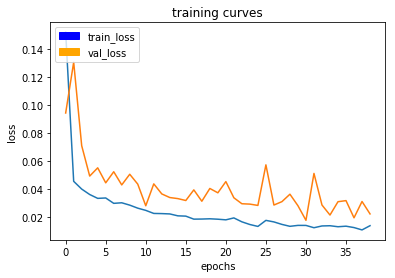

128/128 [==============================] - 77s - loss: 0.0139 - val_loss: 0.0224
Epoch 40/100
127/128 [============================>.] - ETA: 0s - loss: 0.0125

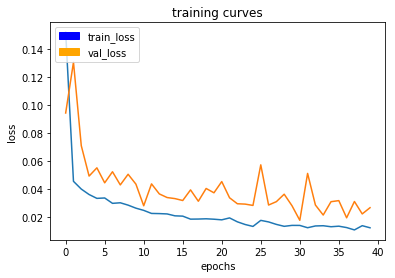

128/128 [==============================] - 77s - loss: 0.0125 - val_loss: 0.0268
Epoch 41/100
127/128 [============================>.] - ETA: 0s - loss: 0.0123

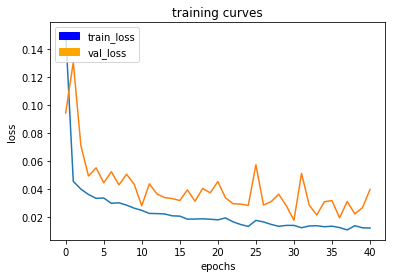

128/128 [==============================] - 77s - loss: 0.0123 - val_loss: 0.0398
Epoch 42/100
127/128 [============================>.] - ETA: 0s - loss: 0.0130

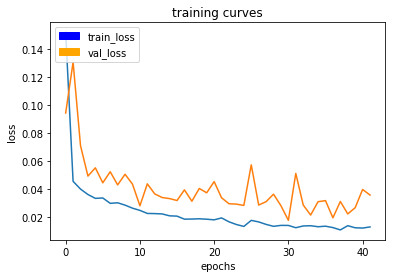

128/128 [==============================] - 77s - loss: 0.0131 - val_loss: 0.0358
Epoch 43/100
127/128 [============================>.] - ETA: 0s - loss: 0.0116

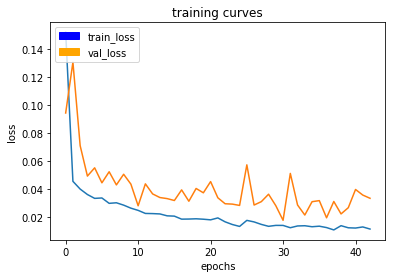

128/128 [==============================] - 78s - loss: 0.0115 - val_loss: 0.0335
Epoch 44/100
127/128 [============================>.] - ETA: 0s - loss: 0.0106

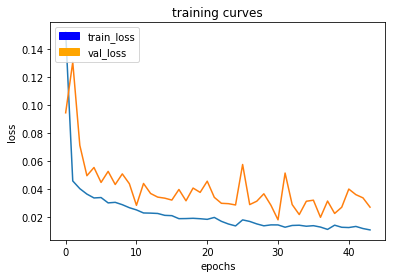

128/128 [==============================] - 78s - loss: 0.0106 - val_loss: 0.0269
Epoch 45/100
127/128 [============================>.] - ETA: 0s - loss: 0.0101

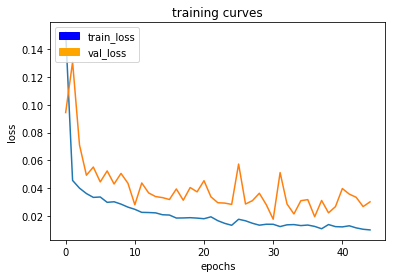

128/128 [==============================] - 77s - loss: 0.0101 - val_loss: 0.0303
Epoch 46/100
127/128 [============================>.] - ETA: 0s - loss: 0.0120

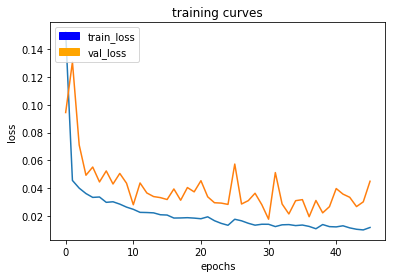

128/128 [==============================] - 77s - loss: 0.0120 - val_loss: 0.0451
Epoch 47/100
127/128 [============================>.] - ETA: 0s - loss: 0.0135

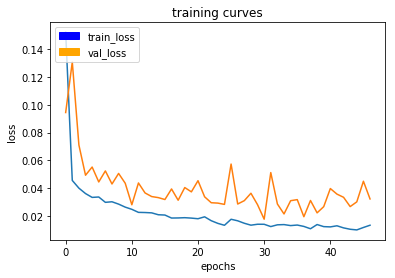

128/128 [==============================] - 77s - loss: 0.0135 - val_loss: 0.0323
Epoch 48/100
127/128 [============================>.] - ETA: 0s - loss: 0.0145

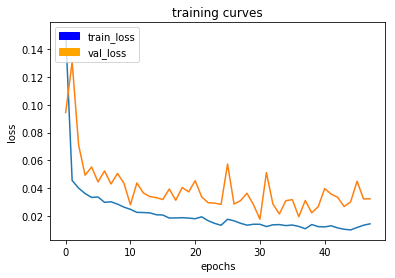

128/128 [==============================] - 78s - loss: 0.0145 - val_loss: 0.0325
Epoch 49/100
127/128 [============================>.] - ETA: 0s - loss: 0.0120

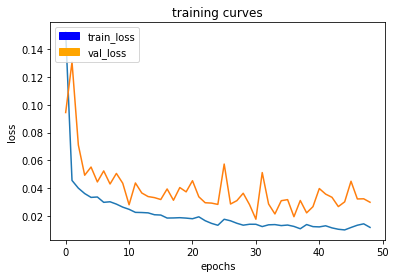

128/128 [==============================] - 77s - loss: 0.0119 - val_loss: 0.0300
Epoch 50/100
127/128 [============================>.] - ETA: 0s - loss: 0.0110

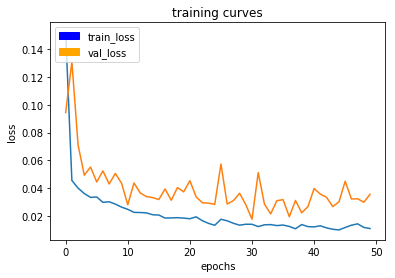

128/128 [==============================] - 78s - loss: 0.0110 - val_loss: 0.0357
Epoch 51/100
127/128 [============================>.] - ETA: 0s - loss: 0.0102

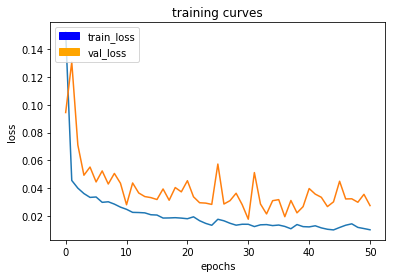

128/128 [==============================] - 78s - loss: 0.0102 - val_loss: 0.0276
Epoch 52/100
127/128 [============================>.] - ETA: 0s - loss: 0.0099

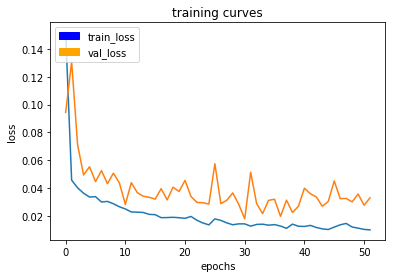

128/128 [==============================] - 78s - loss: 0.0099 - val_loss: 0.0329
Epoch 53/100
127/128 [============================>.] - ETA: 0s - loss: 0.0102

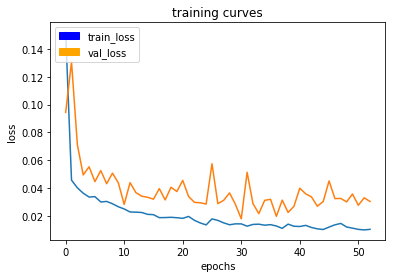

128/128 [==============================] - 78s - loss: 0.0102 - val_loss: 0.0303
Epoch 54/100
127/128 [============================>.] - ETA: 0s - loss: 0.0097

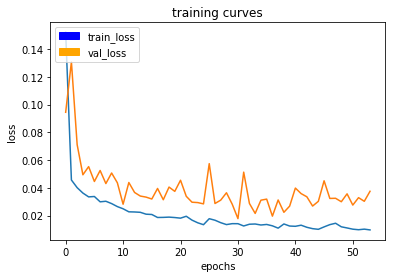

128/128 [==============================] - 77s - loss: 0.0097 - val_loss: 0.0375
Epoch 55/100
127/128 [============================>.] - ETA: 0s - loss: 0.0113

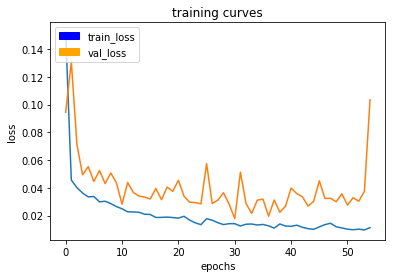

128/128 [==============================] - 77s - loss: 0.0113 - val_loss: 0.1035
Epoch 56/100
127/128 [============================>.] - ETA: 0s - loss: 0.0140

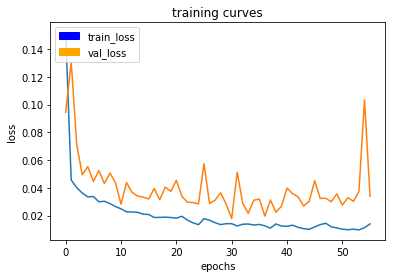

128/128 [==============================] - 77s - loss: 0.0140 - val_loss: 0.0340
Epoch 57/100
127/128 [============================>.] - ETA: 0s - loss: 0.0196

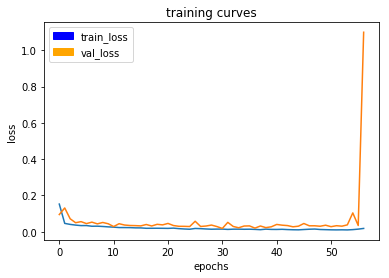

128/128 [==============================] - 77s - loss: 0.0197 - val_loss: 1.1001
Epoch 58/100
127/128 [============================>.] - ETA: 0s - loss: 0.0332

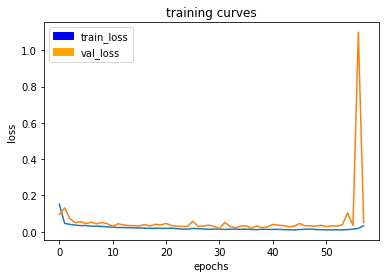

128/128 [==============================] - 77s - loss: 0.0330 - val_loss: 0.0509
Epoch 59/100
127/128 [============================>.] - ETA: 0s - loss: 0.0278

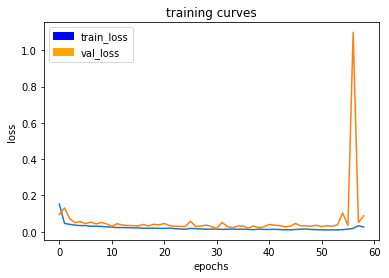

128/128 [==============================] - 77s - loss: 0.0279 - val_loss: 0.0869
Epoch 60/100
127/128 [============================>.] - ETA: 0s - loss: 0.0237

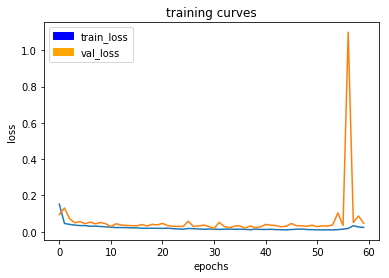

128/128 [==============================] - 78s - loss: 0.0236 - val_loss: 0.0462
Epoch 61/100
127/128 [============================>.] - ETA: 0s - loss: 0.0177

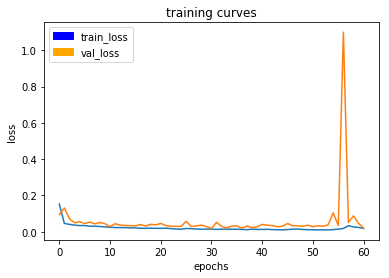

128/128 [==============================] - 77s - loss: 0.0177 - val_loss: 0.0191
Epoch 62/100
127/128 [============================>.] - ETA: 0s - loss: 0.0150

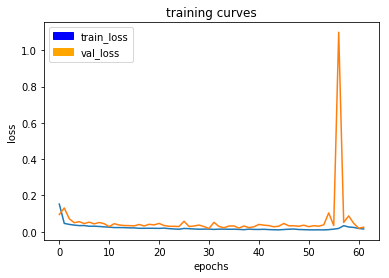

128/128 [==============================] - 77s - loss: 0.0150 - val_loss: 0.0245
Epoch 63/100
127/128 [============================>.] - ETA: 0s - loss: 0.0138

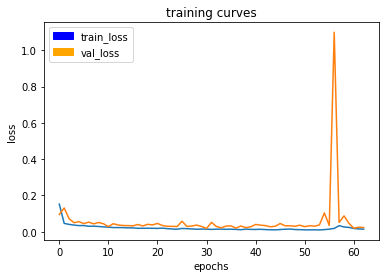

128/128 [==============================] - 78s - loss: 0.0140 - val_loss: 0.0228
Epoch 64/100
127/128 [============================>.] - ETA: 0s - loss: 0.0122

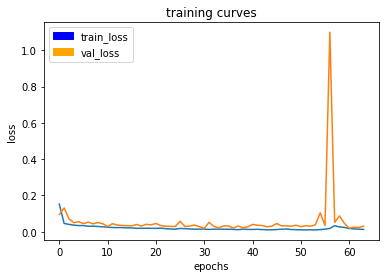

128/128 [==============================] - 77s - loss: 0.0122 - val_loss: 0.0308
Epoch 65/100
127/128 [============================>.] - ETA: 0s - loss: 0.0114

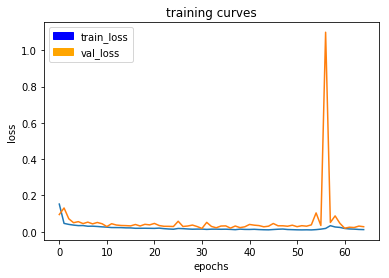

128/128 [==============================] - 77s - loss: 0.0114 - val_loss: 0.0273
Epoch 66/100
127/128 [============================>.] - ETA: 0s - loss: 0.0109

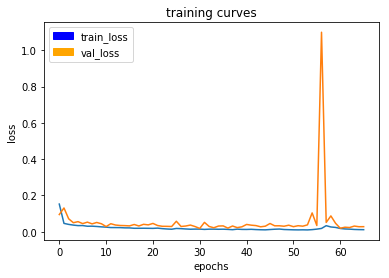

128/128 [==============================] - 77s - loss: 0.0109 - val_loss: 0.0276
Epoch 67/100
127/128 [============================>.] - ETA: 0s - loss: 0.0107

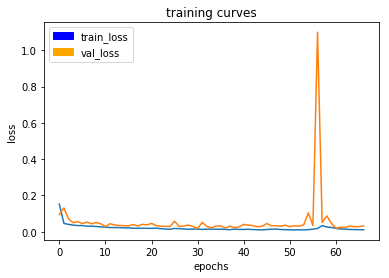

128/128 [==============================] - 77s - loss: 0.0107 - val_loss: 0.0319
Epoch 68/100
127/128 [============================>.] - ETA: 0s - loss: 0.0104

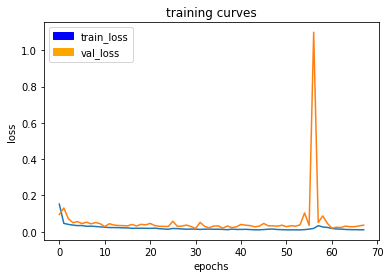

128/128 [==============================] - 78s - loss: 0.0104 - val_loss: 0.0358
Epoch 69/100
127/128 [============================>.] - ETA: 0s - loss: 0.0100

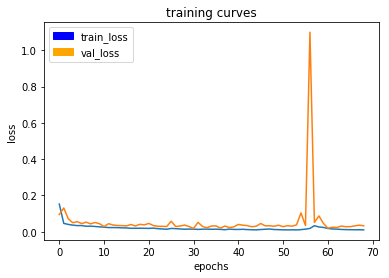

128/128 [==============================] - 77s - loss: 0.0100 - val_loss: 0.0325
Epoch 70/100
127/128 [============================>.] - ETA: 0s - loss: 0.0099

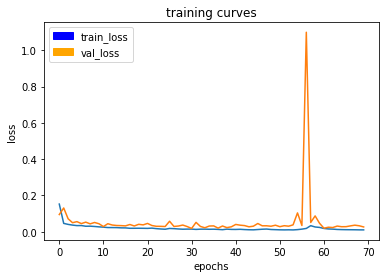

128/128 [==============================] - 77s - loss: 0.0099 - val_loss: 0.0260
Epoch 71/100
127/128 [============================>.] - ETA: 0s - loss: 0.0098

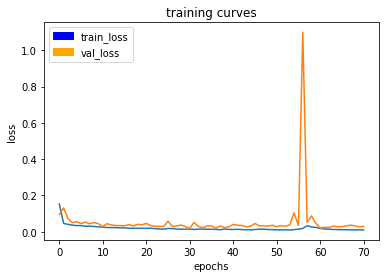

128/128 [==============================] - 78s - loss: 0.0098 - val_loss: 0.0289
Epoch 72/100
127/128 [============================>.] - ETA: 0s - loss: 0.0098

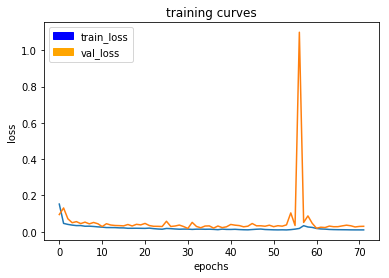

128/128 [==============================] - 77s - loss: 0.0098 - val_loss: 0.0296
Epoch 73/100
127/128 [============================>.] - ETA: 0s - loss: 0.0104

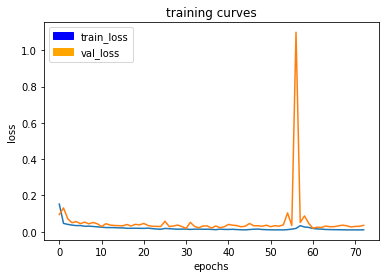

128/128 [==============================] - 77s - loss: 0.0104 - val_loss: 0.0350
Epoch 74/100
127/128 [============================>.] - ETA: 0s - loss: 0.0095

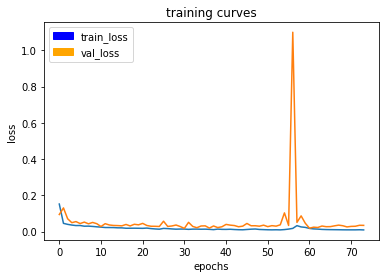

128/128 [==============================] - 77s - loss: 0.0095 - val_loss: 0.0345
Epoch 75/100
127/128 [============================>.] - ETA: 0s - loss: 0.0106

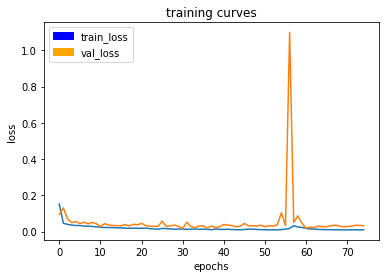

128/128 [==============================] - 77s - loss: 0.0106 - val_loss: 0.0327
Epoch 76/100
127/128 [============================>.] - ETA: 0s - loss: 0.0106

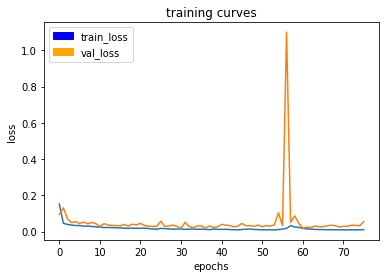

128/128 [==============================] - 78s - loss: 0.0106 - val_loss: 0.0546
Epoch 77/100
127/128 [============================>.] - ETA: 0s - loss: 0.0108

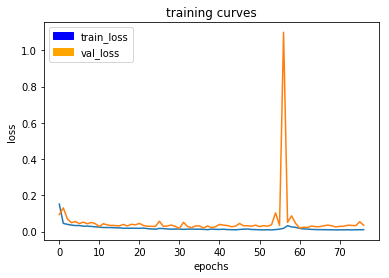

128/128 [==============================] - 78s - loss: 0.0108 - val_loss: 0.0353
Epoch 78/100
127/128 [============================>.] - ETA: 0s - loss: 0.0096

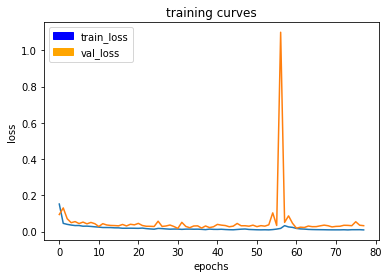

128/128 [==============================] - 77s - loss: 0.0096 - val_loss: 0.0328
Epoch 79/100
127/128 [============================>.] - ETA: 0s - loss: 0.0125

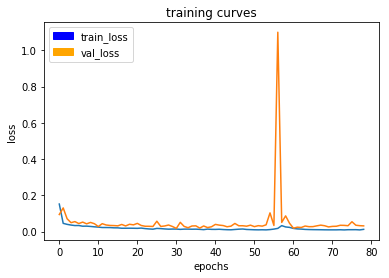

128/128 [==============================] - 78s - loss: 0.0125 - val_loss: 0.0317
Epoch 80/100
127/128 [============================>.] - ETA: 0s - loss: 0.0103

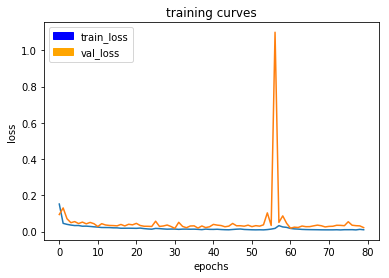

128/128 [==============================] - 77s - loss: 0.0103 - val_loss: 0.0221
Epoch 81/100
127/128 [============================>.] - ETA: 0s - loss: 0.0097

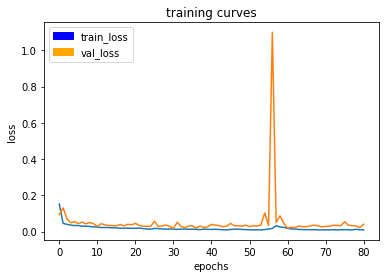

128/128 [==============================] - 78s - loss: 0.0098 - val_loss: 0.0410
Epoch 82/100
127/128 [============================>.] - ETA: 0s - loss: 0.0091

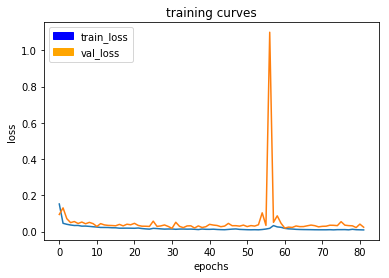

128/128 [==============================] - 77s - loss: 0.0091 - val_loss: 0.0239
Epoch 83/100
127/128 [============================>.] - ETA: 0s - loss: 0.0087

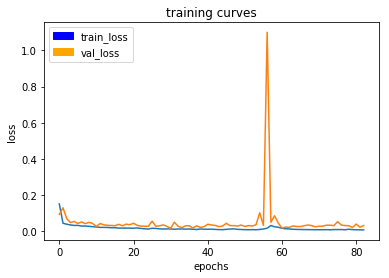

128/128 [==============================] - 78s - loss: 0.0087 - val_loss: 0.0328
Epoch 84/100
127/128 [============================>.] - ETA: 0s - loss: 0.0083

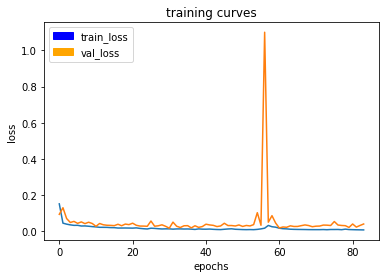

128/128 [==============================] - 78s - loss: 0.0083 - val_loss: 0.0410
Epoch 85/100
127/128 [============================>.] - ETA: 0s - loss: 0.0085

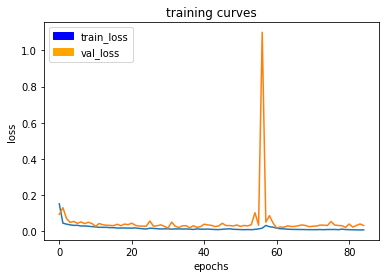

128/128 [==============================] - 77s - loss: 0.0085 - val_loss: 0.0327
Epoch 86/100
127/128 [============================>.] - ETA: 0s - loss: 0.0081

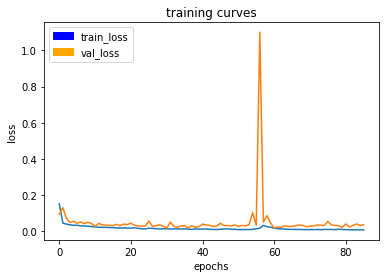

128/128 [==============================] - 77s - loss: 0.0081 - val_loss: 0.0366
Epoch 87/100
127/128 [============================>.] - ETA: 0s - loss: 0.0081

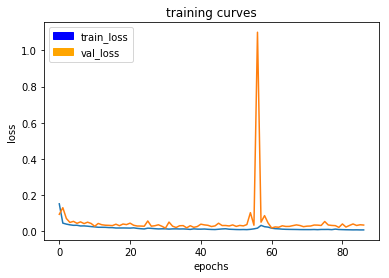

128/128 [==============================] - 77s - loss: 0.0081 - val_loss: 0.0350
Epoch 88/100
127/128 [============================>.] - ETA: 0s - loss: 0.0080

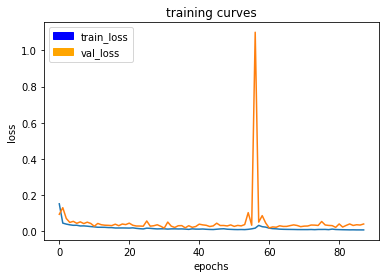

128/128 [==============================] - 78s - loss: 0.0080 - val_loss: 0.0407
Epoch 89/100
127/128 [============================>.] - ETA: 0s - loss: 0.0094

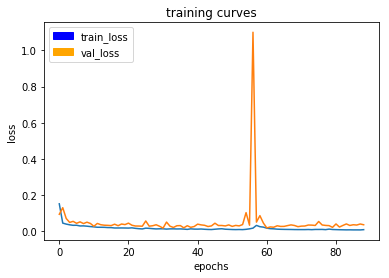

128/128 [==============================] - 77s - loss: 0.0094 - val_loss: 0.0365
Epoch 90/100
127/128 [============================>.] - ETA: 0s - loss: 0.0099

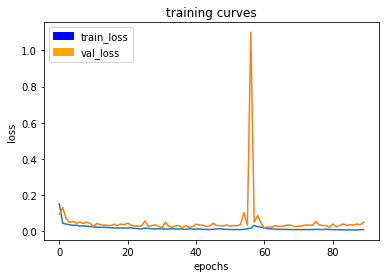

128/128 [==============================] - 77s - loss: 0.0099 - val_loss: 0.0503
Epoch 91/100
127/128 [============================>.] - ETA: 0s - loss: 0.0119

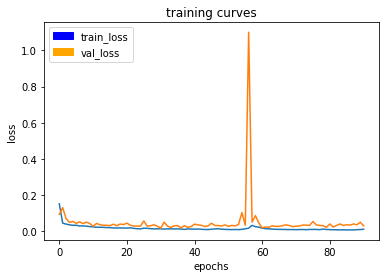

128/128 [==============================] - 77s - loss: 0.0119 - val_loss: 0.0304
Epoch 92/100
127/128 [============================>.] - ETA: 0s - loss: 0.0091

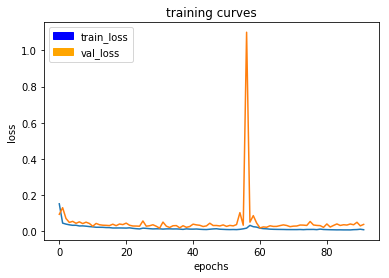

128/128 [==============================] - 77s - loss: 0.0091 - val_loss: 0.0384
Epoch 93/100
127/128 [============================>.] - ETA: 0s - loss: 0.0083

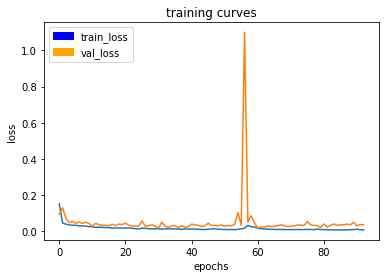

128/128 [==============================] - 77s - loss: 0.0083 - val_loss: 0.0354
Epoch 94/100
127/128 [============================>.] - ETA: 0s - loss: 0.0095

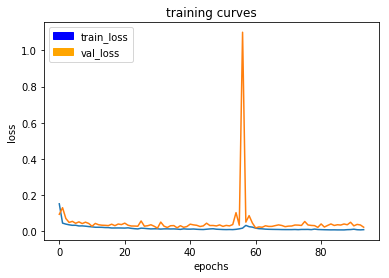

128/128 [==============================] - 77s - loss: 0.0095 - val_loss: 0.0229
Epoch 95/100
127/128 [============================>.] - ETA: 0s - loss: 0.0082

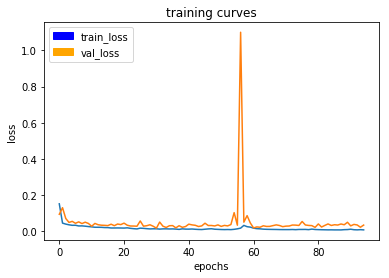

128/128 [==============================] - 77s - loss: 0.0082 - val_loss: 0.0347
Epoch 96/100
127/128 [============================>.] - ETA: 0s - loss: 0.0080

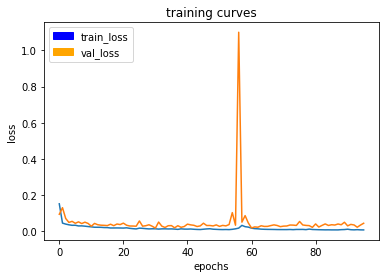

128/128 [==============================] - 77s - loss: 0.0080 - val_loss: 0.0447
Epoch 97/100
127/128 [============================>.] - ETA: 0s - loss: 0.0093

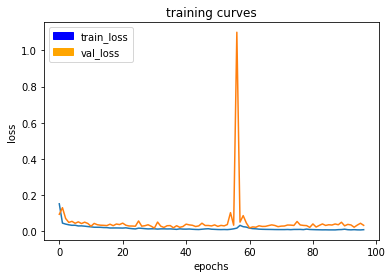

128/128 [==============================] - 78s - loss: 0.0093 - val_loss: 0.0333
Epoch 98/100
127/128 [============================>.] - ETA: 0s - loss: 0.0087

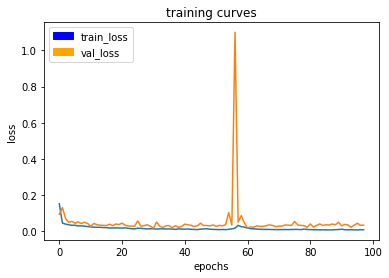

128/128 [==============================] - 77s - loss: 0.0087 - val_loss: 0.0343
Epoch 99/100
127/128 [============================>.] - ETA: 0s - loss: 0.0079

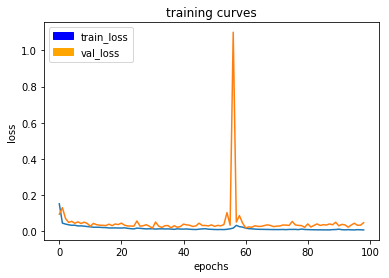

128/128 [==============================] - 77s - loss: 0.0078 - val_loss: 0.0476
Epoch 100/100
127/128 [============================>.] - ETA: 0s - loss: 0.0076

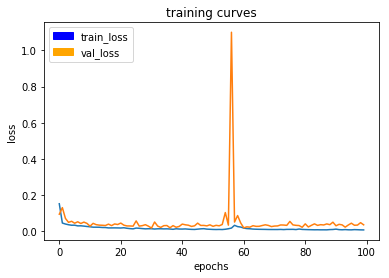

128/128 [==============================] - 77s - loss: 0.0076 - val_loss: 0.0357


In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [66]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [67]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [68]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

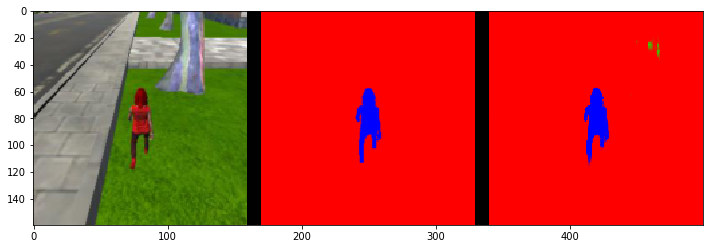

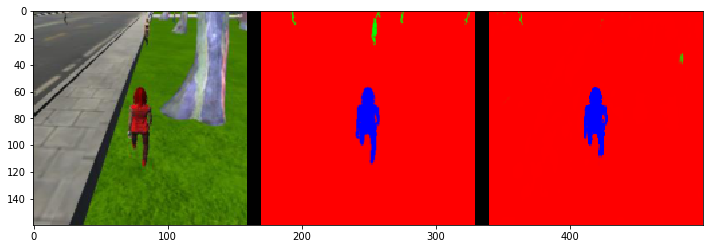

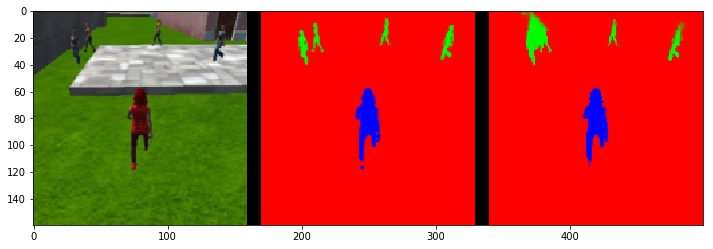

In [69]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

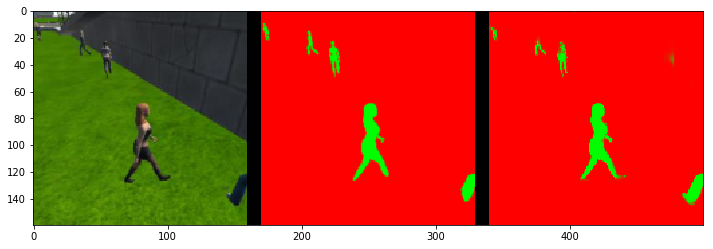

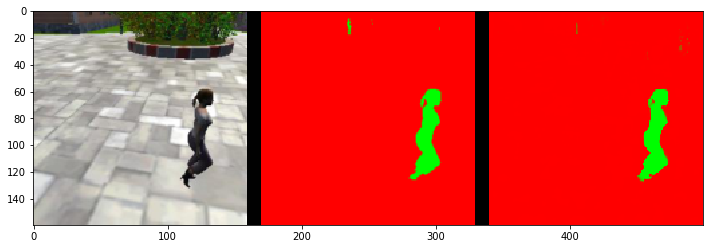

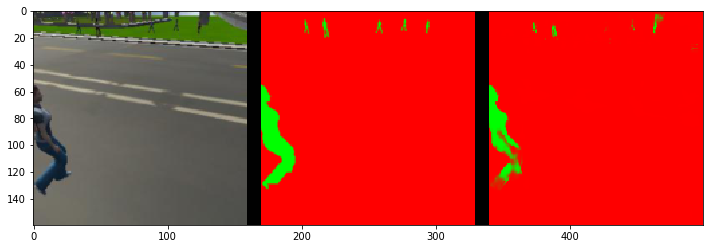

In [70]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

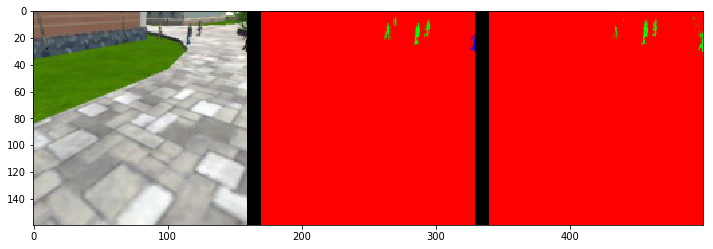

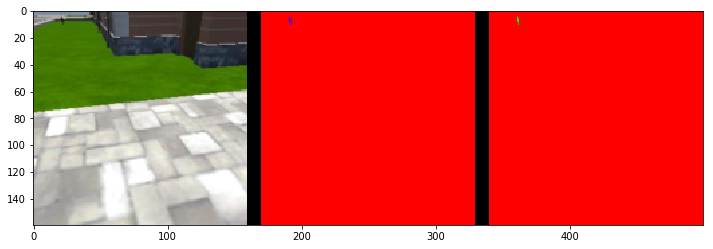

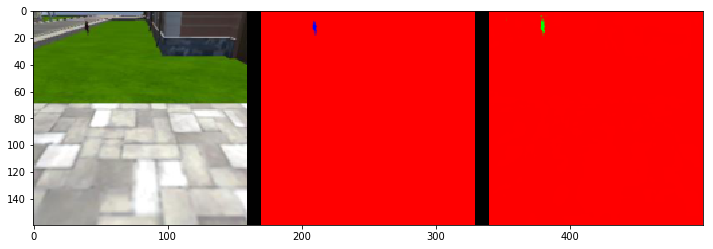

In [71]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [72]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9964117114957431
average intersection over union for other people is 0.3705529259913311
average intersection over union for the hero is 0.9007768515835466
number true positives: 539, number false positives: 0, number false negatives: 0


In [73]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9882120549677823
average intersection over union for other people is 0.7663156213720278
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 31, number false negatives: 0


In [74]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.99682824826556
average intersection over union for other people is 0.44495233936239614
average intersection over union for the hero is 0.14111539179311094
number true positives: 83, number false positives: 1, number false negatives: 218


In [75]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.713302752293578


In [76]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.5209461216883288


In [77]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.3715923023969501
